### Unsupervised Customer Segmentation for Marketing Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

**Data Preparation and Preprocessing**

In [3]:
try:
    df = pd.read_csv("customer_segmentation_data.csv")
    print("SUCCESS: Data Loaded Successfully.")
except FileNotFoundError:
    print("ERROR: CSV file not found. Please check the file path.")
    raise

SUCCESS: Data Loaded Successfully.


In [5]:
df.head()

,id,age,gender,income,spending_score,membership_years,purchase_frequency,preferred_category,last_purchase_amount
0,1,38,Female,99342,90,3,24,Groceries,113.53
1,2,21,Female,78852,60,2,42,Sports,41.93
2,3,60,Female,126573,30,2,28,Clothing,424.36
3,4,40,Other,47099,74,9,5,Home & Garden,991.93
4,5,65,Female,140621,21,3,25,Electronics,347.08


In [6]:
df.info

<bound method DataFrame.info of        id  age  gender  income  spending_score  membership_years  \
0       1   38  Female   99342              90                 3   
1       2   21  Female   78852              60                 2   
2       3   60  Female  126573              30                 2   
3       4   40   Other   47099              74                 9   
4       5   65  Female  140621              21                 3   
..    ...  ...     ...     ...             ...               ...   
995   996   57    Male  112170              57                 6   
996   997   23   Other   65337              76                10   
997   998   23    Male  113097              40                 5   
998   999   22  Female  113695              63                 7   
999  1000   36  Female   90420               7                 2   

     purchase_frequency preferred_category  last_purchase_amount  
0                    24          Groceries                113.53  
1                

In [4]:
df.isnull().sum()

id                      0
age                     0
gender                  0
income                  0
spending_score          0
membership_years        0
purchase_frequency      0
preferred_category      0
last_purchase_amount    0
dtype: int64

In [7]:
clustering_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col not in ['CustomerID', 'ID']]

In [8]:
X = df[clustering_cols].copy()

**Standardization and Optimal K Determination**

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

Determine the Optimal Number of Clusters (K)

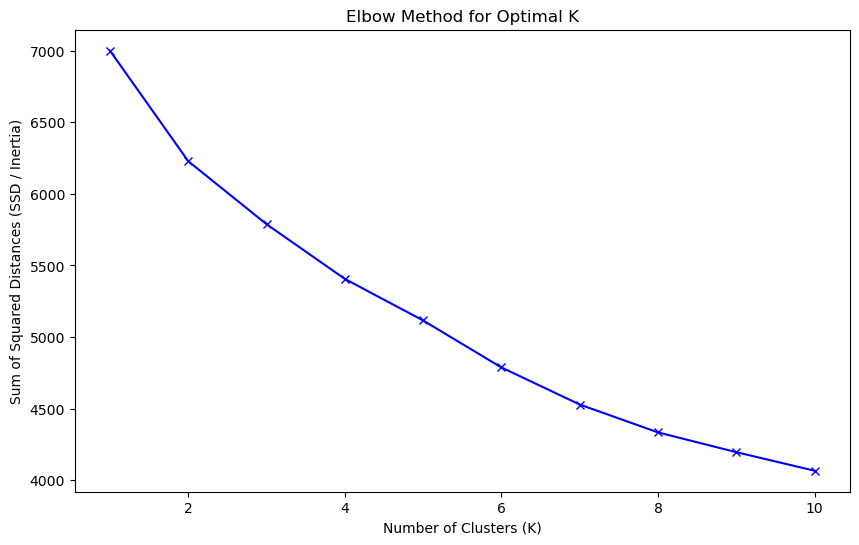

In [10]:
#Elbow Method
ssd = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X_scaled_df)
    ssd.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, ssd, 'bx-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Sum of Squared Distances (SSD / Inertia)")
plt.title("Elbow Method for Optimal K")
plt.show()

In [ ]:
#Silhouette Score (To confirm the elbow point)
silhouette_scores = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X_scaled_df)
    score = silhouette_score(X_scaled_df, kmeans.labels_)
    silhouette_scores[k] = score

print("\nSilhouette Scores (Higher is better):")
print(silhouette_scores)

optimal_k = 5
print(f"\nChosen Optimal Number of Clusters (K): {optimal_k}")


Silhouette Scores (Higher is better):
{2: 0.10840219440494818, 3: 0.09594705368597126, 4: 0.09886947913767044, 5: 0.09827073243603184, 6: 0.10685261455526252, 7: 0.11109259171280084, 8: 0.11390491118919946, 9: 0.11022228291584045, 10: 0.11118002220715024}

Chosen Optimal Number of Clusters (K): 5


**K-Means Model Training and Assignment**

In [13]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto').fit(X_scaled_df)

In [14]:
X['Segment'] = kmeans.labels_
df['Segment'] = kmeans.labels_

In [15]:
print(f"\nK-Means Model Trained Successfully with K={optimal_k}.")
print(f"\nSegmentation Distribution:\n{X['Segment'].value_counts().sort_index()}")


K-Means Model Trained Successfully with K=5.

Segmentation Distribution:
Segment
0    192
1    198
2    217
3    191
4    202
Name: count, dtype: int64


**Results, Analysis, and Visualization**

In [ ]:
segment_summary = X.drop('Segment', axis=1).groupby(X['Segment']).mean().round(2)
segment_counts = df['Segment'].value_counts().sort_index()
segment_summary['Customer_Count'] = segment_counts
segment_summary['Share (%)'] = (segment_counts / segment_counts.sum() * 100).round(2)
print("\n--- K-Means Segment Statistics (Mean Values) ---")
print(segment_summary)


--- K-Means Segment Statistics (Mean Values) ---
            id   age    income  spending_score  membership_years  \
Segment                                                            
0       245.33 36.64  66262.37           39.89              4.96   
1       628.81 37.95 111922.70           55.27              7.25   
2       245.28 51.06 105684.51           57.02              5.84   
3       675.80 56.79  76077.86           62.07              3.64   
4       725.69 36.17  79966.94           38.88              5.53   

         purchase_frequency  last_purchase_amount  Customer_Count  Share (%)  
Segment                                                                       
0                     33.11                544.31             192      19.20  
1                     39.08                521.33             198      19.80  
2                     19.24                377.24             217      21.70  
3                     28.95                576.82             191      19.10  

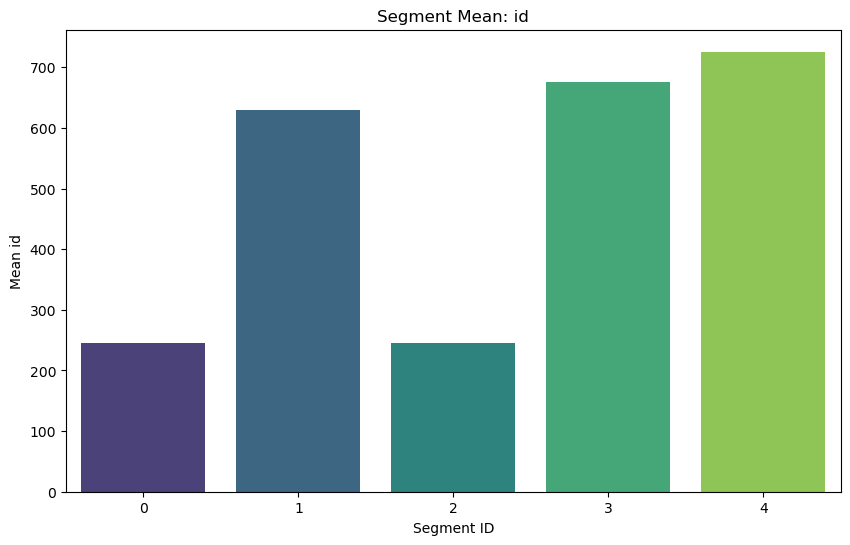

In [ ]:
feature_1 = segment_summary.columns[0] 
feature_2 = segment_summary.columns[1] 
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_summary.index, y=segment_summary[feature_1], palette='viridis')
plt.title(f'Segment Mean: {feature_1}')
plt.xlabel('Segment ID')
plt.ylabel(f'Mean {feature_1}')
plt.show()

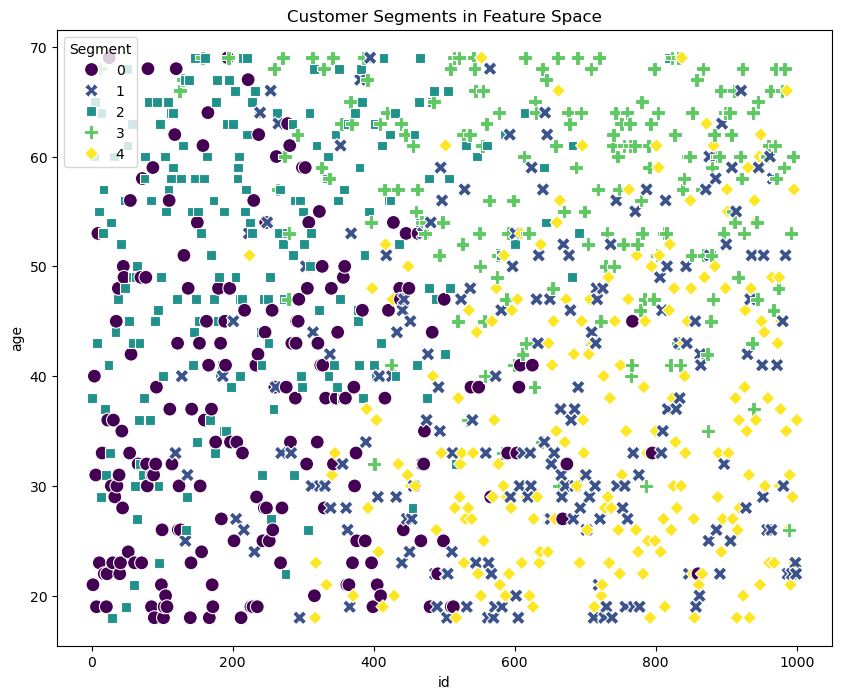

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=feature_1, y=feature_2, hue='Segment', data=X, palette='viridis', style='Segment', s=100)
plt.title('Customer Segments in Feature Space')
plt.xlabel(feature_1)
plt.ylabel(feature_2)
plt.legend(title='Segment')
plt.show()

### Business Interpretation and Conclusion

The K-Means model successfully partitioned the customer base into 5 distinct and meaningful segments based primarily on income, age, and purchasing behavior.

### I. Segment Profiles and Naming:

| Segment ID | Profile Summary | Customer Count | Business Name |
|:----------:|:----------------------------------|:---------------|:------------------------|
| **0** | **Mid-Age, High Frequency, High Value** | 192 (19.2%)    | **Loyal Gold Spenders** |
| **1** | **Highest Income, Highest Tenure** | 198 (19.8%)    | **Affluent Elite** |
| **2** | **Oldest Age, High Income, Mid Spending** | 217 (21.7%)    | **Stable High-Earners** |
| **3** | **Oldest Age, Lowest Income, High Spending** | 191 (19.1%)    | **Elderly Value Seekers**|
| **4** | **Mid-Age, Lowest Frequency/Spending** | 202 (20.2%)    | **Passive / At-Risk** |

### II. Detailed Segment Analysis:

1.  **Segment 1: Affluent Elite (Highest Value)**
    * **Characteristics:** Highest Annual Income (111,922), Highest Membership Years (7.25), High Spending Score (55.27). High Purchase Frequency (39.08).
    * **Insight:** These are the most established, wealthiest, and highest-frequency customers. They value the brand and are a core pillar of revenue.
    * **Strategy:** **Retention and Premiumization.** Offer exclusive, personalized concierge services or premium loyalty tiers. Never target with standard discounts; focus on early access and luxury upsells.

2.  **Segment 0: Loyal Gold Spenders**
    * **Characteristics:** High Purchase Frequency (33.11), Highest Last Purchase Amount (544.31), Mid-High Income (66,262). Mid-Age (36.64).
    * **Insight:** Highly transactional customers who frequently make large, recent purchases. They are highly active and responsive.
    * **Strategy:** **Incentivize Volume.** Offer tiered incentives for increasing order size or frequency. Use personalized bundles based on their last high-value purchase.

3.  **Segment 3: Elderly Value Seekers**
    * **Characteristics:** Lowest Income (76,077), Oldest Mean Age (56.79), Highest Spending Score (62.07). High Last Purchase Amount (576.82).
    * **Insight:** Despite low income, they have the highest *Spending Score* and *high purchase value*, suggesting they are highly motivated by sales or perceive high value in certain items.
    * **Strategy:** **Targeted Promotions.** Use data to identify which items they highly value and target them with personalized, high-impact discounts on those specific categories to maintain high spending activity.

4.  **Segment 4: Passive / At-Risk**
    * **Characteristics:** Lowest Purchase Frequency (13.85), Lowest Spending Score (38.88), Low Last Purchase Amount (458.33).
    * **Insight:** The least active and least engaged group. They are likely slipping away or only purchase out of necessity.
    * **Strategy:** **Re-activation and Value Awareness.** Run win-back campaigns with strong, simple incentives (e.g., free shipping or a significant introductory discount). Focus messaging on the unique benefits they are missing out on.

5.  **Segment 2: Stable High-Earners**
    * **Characteristics:** High Income (105,684), Oldest Mean Age (51.06), but Low Purchase Frequency (19.24).
    * **Insight:** Wealthy, older customers who shop infrequently. They may be loyal to another brand or only buy specific items.
    * **Strategy:** **High-Value/Low-Frequency Offers.** Use relationship marketing and personalized outreach. Offer product curation services or focus on luxury items that require less frequent purchasing.

### III. Conclusion:

The segmentation analysis provides clear, data-driven personas for the marketing team. The strongest recommendation is to shift focus from the large, low-engagement segments (like Segment 4) to maximizing the potential of the high-value groups (Segments 1 and 0), ensuring the highest possible return on investment (ROI) from marketing expenditures.